In [1]:
from motor import Motor,EMRAX208MV,EMRAX208HV,EMRAX228HV,EMRAX228MV
import battery
from battery import battery,batteryPack,batt_models
import pandas as pd
import numpy as np

In [2]:
lgHE2= battery(r'battery_soc_curves/lgHE2ahCurve.csv')
energus300v = batteryPack(lgHE2,8,72,'ENERGUS72s8p')
print(energus300v)

# THis curve is not real, I just adjusted the points of the HE2 curve
cosmx= battery(r'battery_soc_curves/COSMXahCurve.csv',capacity=13000,resistance=1.5/1000,c_rate=25)
cosmx300v = batteryPack(cosmx,2,72,'COSMX72s2p')
cosmx400v = batteryPack(cosmx,1,96,'COSMX96s1p')
cosmx600v= batteryPack(cosmx,1,144,'COSMX144s1p')
print(cosmx300v)
print(cosmx400v)
print(cosmx600v)


ENERGUS72s8p 72S 8P, 20.0Ah, Max 302.40V, Nominal 259.2V
COSMX72s2p 72S 2P, 26.0Ah, Max 302.40V, Nominal 259.2V
COSMX96s1p 96S 1P, 13.0Ah, Max 403.20V, Nominal 345.6V
COSMX144s1p 144S 1P, 13.0Ah, Max 604.80V, Nominal 518.4V


In [3]:
current_motor = EMRAX228MV

In [4]:
rpm = 5000
torque = 240
last_voltage = 0
last_power = 0
last_acc_required_power = 0
current_voltage = energus300v.getInstantaneousVoltage(0)
id,iq,motortorque,speed,vout = EMRAX228MV.get_qd_currents(rpm,torque,current_voltage)
motor_power = motortorque*rpm/9.5488
print(f"Id: {id} Iq: {iq} Motor torque: {motortorque} Rpm: {rpm} Power: {motor_power}W")
acc_required_power = motor_power / 0.95 / 0.95
acc_required_power



Id: -221 Iq: 286.09238626700454 Motor torque: 163.21427590339476 Rpm: 5000 Power: 85463.23930933456W


94696.11003804384

In [5]:
# try to iterate to get pack sag and motor power at sagged v
# print(f"Id: {id} Iq: {iq} Motor torque: {motortorque} Rpm: {rpm} Power: {motor_power}W")

# last_voltage = current_voltage
# calculate voltage sag
print(energus300v.voltage,motor_power,acc_required_power)
while last_voltage != current_voltage:
    # last_power=motor_power
    # last_acc_required_power=acc_required_power
    last_voltage = current_voltage
    current = acc_required_power / current_voltage
    current_voltage = energus300v.getInstantaneousVoltage(current)
    # print(f"Last voltage: {last_voltage:.2f} CUrrent voltage: {current_voltage:.2f} Last Power: {last_acc_required_power:.2f} Current : {current:.2f}")

    id,iq,motortorque,speed,vout = EMRAX228MV.get_qd_currents(rpm,torque,current_voltage)
    motor_power = motortorque*rpm/9.5488
    # print(f"Motor torque: {motortorque:.2f} Current Power: {motor_power:.2f}W Last Power: {last_power:.2f}")
    acc_required_power = motor_power / 0.95 / 0.95
    print(current_voltage,motor_power,acc_required_power)


        

302.40566628424364 85463.23930933456 94696.11003804384
211.93875630155756 47823.5199548089 52990.04981142261
230.17335890607916 56147.00810988563 62212.75136829434
224.31989668988268 53541.23366744887 59325.46666753338
226.00081957577322 54295.176867098766 60160.86079456927
225.5011987864 54071.57607949184 59913.103689187636
225.6482222043046 54137.41798129786 59986.058705039184
225.60482916444104 54117.98888988489 59964.53062591124
225.6176251683389 54123.71858340725 59970.879316794744
225.61385083234816 54122.02856930685 59969.00672499375
225.61496403376523 54122.527023967705 59969.5590293271
225.61463569914582 54122.38000683235 59969.39612945414
225.61473253958098 54122.423368721815 59969.44417586905
225.61470397698776 54122.41057935493 59969.43000482541
225.61471240137436 54122.41435151154 59969.43418450033
225.61470991664544 54122.41323893363 59969.432951727016
225.61471064950325 54122.41356708269 59969.433315327085
225.61471043335064 54122.413470296815 59969.433208085116
225.6147

In [6]:
def calc_motor_battery_instantaneous_power(batterypack: batteryPack, motor: Motor, rpm: int, torque: float, power_limit:float = 80000,efficiency1:float = 0.95, efficiency2:float = 0.95, max_iterations: int = 100, rolling_average_window: int = 20, convergence_threshold: float = 5.0):
    """Calculate the instantaneous power of a motor with a batteryPack as the source
    Dynamically sags battery pack and recalculates motor power (since voltage decreases, the available torque may decrease too)

    Args:
        batterypack (batteryPack): battery pack object which will be the power source
        motor (Motor): motor object to calculate power for  
        rpm (int): rpm target for motor
        torque (float): torque target for motor
        power_limit (float, optional): power limit for the accumulator. Defaults to 80000.
        max_iterations (int, optional): maxmimum iteration count to solve. Defaults to 1000.
        rolling_average_window (int, optional): the amount of averages that will be taken to . Defaults to 100.
        convergence_threshold (float, optional): _description_. Defaults to 1.0.

    Returns:
        _type_: _description_
    """
    # get starting state
    current_motor = motor
    pack = batterypack
    last_voltage = 0
    power_limit = min(power_limit, batterypack.getMaxPowerOut())

    current_voltage = pack.getInstantaneousVoltage(0)
    if torque * rpm / 9.5488 > (power_limit * efficiency1 * efficiency2):
        torque = (power_limit * efficiency1 * efficiency2) / rpm * 9.5488
        
    id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, current_voltage, powerlim=80000)
    motor_power = motortorque * rpm / 9.5488
    # print(f"Id: {id} Iq: {iq} Motor torque: {motortorque} Rpm: {rpm} Power: {motor_power}W")
    acc_required_power = motor_power / efficiency1 / efficiency2

    voltage_history = []
    iterations = 0
    while (iterations < max_iterations) & (round(last_voltage, 2) != round(current_voltage, 2)):
        last_voltage = current_voltage
        current = acc_required_power / current_voltage
        current_voltage = pack.getInstantaneousVoltage(current)

        id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, current_voltage)
        motor_power = motortorque * rpm / 9.5488
        acc_required_power = motor_power / efficiency1 / efficiency2
        
        voltage_history.append(current_voltage)
        if len(voltage_history) > rolling_average_window:
            voltage_history.pop(0)
            average_voltage = sum(voltage_history) / len(voltage_history)
            # print(f"Last V: {last_voltage:.3f} Current V: {current_voltage:.3f} Id: {id:.3f} Iq: {iq:.3f} Torque: {torque:.3f} Power: {motor_power:.3f} Avg V: {average_voltage:.3f}")

            if abs(average_voltage - current_voltage) < convergence_threshold:
                # print(f"Converged after {iterations} iterations.")
                id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, average_voltage)
                motor_power = motortorque * rpm / 9.5488
                acc_required_power = motor_power / efficiency1 / efficiency2
                current = acc_required_power / average_voltage
                current_voltage = average_voltage
                break

        iterations += 1

    if iterations == max_iterations:
        print(f"Warning: Maximum number of iterations reached without convergence. {motor.name} {rpm} {torque}")
        print(f"Average: {average_voltage} Current: {current_voltage} Error: {abs(average_voltage - current_voltage)}")
        print(voltage_history)
        out_v = min(voltage_history)
        id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, out_v)
        motor_power = motortorque * rpm / 9.5488
        acc_required_power = motor_power / efficiency1 / efficiency2
        current = acc_required_power / out_v
        current_voltage = out_v

    return id, iq, motortorque, motor_power, acc_required_power, current, current_voltage,vout





In [7]:
print(energus300v.cell.resistance)

0.032100000000000004


In [8]:

def battery_power_out_calc(accumulator:batteryPack,power:int):
        if power > accumulator.getMaxPowerOut():
            power = accumulator.getMaxPowerOut()
        last_voltage = 0
        current = 0
        current_voltage = accumulator.voltage
        while round(last_voltage,2) != round(current_voltage,2):
            last_voltage = current_voltage
            current = power / current_voltage
            current_voltage = accumulator.getInstantaneousVoltage(current)
            # print(f"Last voltage: {last_voltage} Current voltage: {current_voltage} Power: {power} CUrent : {current}")
        # print(f"Solved for {power}, {current_voltage}V {current}A {current*current_voltage}")
        return current_voltage,current,power

def calcmotor_battery_pwr(battery: batteryPack, motor: Motor, rpm, torque,efficiency1=1.0,efficiency2=1.0):
    
    power_limit = min(80000, battery.getMaxPowerOut())
    if torque * rpm / 9.5488 > (power_limit * efficiency1 * efficiency2):
        torque = (power_limit * efficiency1 * efficiency2) / rpm * 9.5488
        
    motor_power = torque * rpm / 9.5488  # watts
    
    max_iterations = 100  # Maximum number of iterations
    iteration = 0
    
    while True:
        battery_voltage, battery_current, battery_power = battery_power_out_calc(battery, motor_power / efficiency1 / efficiency2)    
        id, iq, motor_torque, speed, vout = motor.get_qd_currents(rpm, torque, battery_voltage,powerlim=(battery_power * (efficiency1*efficiency2)))
        motor_power = motor_torque * rpm / 9.5488
        ratio = motor_power / battery_power
        
        print(f"motor_power: {motor_power}, battery_power: {battery_power}, ratio: {ratio}")
        
        if abs(ratio -(efficiency1*efficiency2)) <= 0.005:
            print("Converged!")
            break
        
        # Nudge motor power towards target ratio
        if ratio < 0.9025:
            motor_power *= 1.01
            print("nudged up")
        elif ratio > 0.9025:
            print("nudged down")
            motor_power *= 0.99
        
        iteration += 1
    else:
        print("Maximum iterations reached without convergence.")
        
    return id, iq, motor_torque, motor_power, battery_power, battery_current, battery_voltage


# calcmotor_battery_pwr(energus300v,EMRAX228MV,6080,230)

In [9]:
calc_motor_battery_instantaneous_power(energus300v,EMRAX208MV,2849,160)

(0,
 425,
 149.0475,
 44470.12478007708,
 49274.37648762004,
 201.86775518467803,
 244.08607181139013,
 137.80623257427413)

In [10]:
def pdapply_motor_power_battery_calc(row,battery,motor:Motor,rpmkey,torquekey):
    id,iq,motortorque,motor_power,acc_required_power,current,current_voltage,vout = calc_motor_battery_instantaneous_power(batterypack=battery,motor=motor,rpm=row[rpmkey],torque=row[torquekey])
    w = row[rpmkey] * 2 * np.pi / 60
    w_e = w * motor.poles
    vd,vq = motor.get_voltages(w_e,id,iq)
    return pd.Series([id,iq,motortorque,motor_power,acc_required_power,current,current_voltage,vout,vd,vq])

def pdapply_motor_power_battery_calc_better(row,battery,motor,rpmkey,torquekey):
    id,iq,motortorque,motor_power,acc_required_power,current,current_voltage = calcmotor_battery_pwr(battery=battery,motor=motor,rpm=row[rpmkey],torque=row[torquekey])
    return pd.Series([id,iq,motortorque,motor_power,acc_required_power,current,current_voltage])


In [11]:
def generate_motor_curve_withsag(battery,motor,maxrpm,rpmincrement,torque):
    df = pd.DataFrame()
    df['rpm'] = range(1,maxrpm,rpmincrement)
    df['t'] = torque
    df[['id','iq','torque','motorpwr','accpwr','current','voltage','vout','vd','vq']] = df.apply(pdapply_motor_power_battery_calc,motor=motor,battery=battery,rpmkey='rpm',torquekey='t',axis=1)
    df['phasepwr'] = (np.sqrt((df['iq']**2 + df['id']**2))) * (np.sqrt((df['vq']**2 + df['vd']**2)))
    # df['phasepwr'] = df['id']*df['vd'] + df['iq']*df['vq']
    return df

In [12]:
accumulator=batt_models.energus300v
# accumulator.discharge(15,3600)
# accumulator.updateVoltage()
# accumulator.voltage

In [13]:
# EMRAX228HV.I_dmax=80
# EMRAX228HV.I_dmax
# 0.05728 is the real number
# EMRAX228HV.Fl = 0.06028
# EMRAX228HV.Ld = 0.000110
# EMRAX228HV.Lq = 0.000225+0.0001
# EMRAX228HV.Rs += .01

In [14]:

data_list = {
    "emrax208mvtorquecurve":generate_motor_curve_withsag(accumulator,EMRAX208MV,7000,10,160),
    "emrax208hvtorquecurve":generate_motor_curve_withsag(accumulator,EMRAX208HV,7000,10,160),
    "emrax228mvtorquecurve":generate_motor_curve_withsag(accumulator,EMRAX228MV,6500,10,230),
    "emrax228hvtorquecurve":generate_motor_curve_withsag(accumulator,EMRAX228HV,6500,10,230),
    }

for key,value in data_list.items():
    value.to_csv(accumulator.name+key+"withSag.csv")
    

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning: invalid value encountered in sqrt
  I_q_fw = np.sqrt((v_max**2/w_e**2)-(self.Ld*I_d_fw+self.Fl)**2)/self.Lq # self.Fl +


Average: 281.81534252546226 Current: 302.40566628424364 Error: 20.59032375878138
[261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364, 261.22501876668076, 302.40566628424364]
Average: 281.93215746703464 Current: 302.40566628424364 Error: 20.473508817208995
[261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364, 261.45864864982553, 302.40566628424364]
Average: 282.04987811857654 Current

In [15]:
# compare no-sag with sagged version
# generate no-sag plots
from motor import generate_power_curve
voltage = accumulator.voltage

no_sag_df_list = {
    "emrax228hvtorquecurve":generate_power_curve(EMRAX228HV,230,6500,100,voltage),
    "emrax208mvtorquecurve":generate_power_curve(EMRAX208MV,160,7000,100,voltage),
    "emrax208hvtorquecurve":generate_power_curve(EMRAX208HV,160,7000,100,voltage),
    "emrax228mvtorquecurve":generate_power_curve(EMRAX228MV,230,6500,100,voltage),
    }
for key,value in data_list.items():
    value.to_csv(accumulator.name+key+"noVoltageSag.csv")
testmotor = EMRAX228MV
testmotor.I_dmax = 0
no_sag_df_list["emrax228mv_zeroD-axis"]=generate_power_curve(testmotor,230,6500,100,voltage)

data_list["emrax228mv_zeroD-axis"] = generate_motor_curve_withsag(accumulator,testmotor,6500,100,230)
    

228HV 6500.0 231 339.4112549695428 Id max: 150 Iq max: 339 Ld: 0.000177 gain: 0.0 Lq: 0.000183 gain: 0.0 Rs: 0.018 Poles: 10.0 Flux: 0.0542
208MV 7000 231 565.685424949238 Id max: 425 Iq max: 425 Ld: 7.35e-05 gain: 0.0 Lq: 7.5e-05 gain: 0.0 Rs: 0.00551 Poles: 10 Flux: 0.02338


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning: invalid value encountered in sqrt
  I_q_fw = np.sqrt((v_max**2/w_e**2)-(self.Ld*I_d_fw+self.Fl)**2)/self.Lq # self.Fl +


208HV 7000 231 339.4112549695428 Id max: 150 Iq max: 283 Ld: 0.0001755 gain: 0.0 Lq: 0.000176 gain: 0.0 Rs: 0.01227 Poles: 10 Flux: 0.03758
228MV 6500.0 231 509.11688245431424 Id max: 221 Iq max: 453 Ld: 9.6e-05 gain: 0.0 Lq: 9.9e-05 gain: 0.0 Rs: 0.0076 Poles: 10.0 Flux: 0.03737
228MV 6500.0 231 509.11688245431424 Id max: 0 Iq max: 453 Ld: 9.6e-05 gain: 0.0 Lq: 9.9e-05 gain: 0.0 Rs: 0.0076 Poles: 10.0 Flux: 0.03737


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning: invalid value encountered in sqrt
  I_q_fw = np.sqrt((v_max**2/w_e**2)-(self.Ld*I_d_fw+self.Fl)**2)/self.Lq # self.Fl +
c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning: invalid value encountered in sqrt
  I_q_fw = np.sqrt((v_max**2/w_e**2)-(self.Ld*I_d_fw+self.Fl)**2)/self.Lq # self.Fl +


Average: 272.7787685590163 Current: 302.40566628424364 Error: 29.62689772522731
[243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364, 243.1518708337889, 302.40566628424364]
Average: 273.5221718086186 Current: 302.40566628424364 Error: 28.883494475625014
[244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364, 244.6386773329935, 302.40566628424364]
Average: 275.3166355026988 Current: 302.40566628424364 Er

In [16]:
import matplotlib.pyplot as plt
for key in data_list.keys():
    print(list(data_list[key]))
    print(list(no_sag_df_list[key]))
    print("")

['rpm', 't', 'id', 'iq', 'torque', 'motorpwr', 'accpwr', 'current', 'voltage', 'vout', 'vd', 'vq', 'phasepwr']
['w', 't', 'v', 'id_t', 'iq_t', 't_t', 'w_t', 'v_max', 'power']

['rpm', 't', 'id', 'iq', 'torque', 'motorpwr', 'accpwr', 'current', 'voltage', 'vout', 'vd', 'vq', 'phasepwr']
['w', 't', 'v', 'id_t', 'iq_t', 't_t', 'w_t', 'v_max', 'power']

['rpm', 't', 'id', 'iq', 'torque', 'motorpwr', 'accpwr', 'current', 'voltage', 'vout', 'vd', 'vq', 'phasepwr']
['w', 't', 'v', 'id_t', 'iq_t', 't_t', 'w_t', 'v_max', 'power']

['rpm', 't', 'id', 'iq', 'torque', 'motorpwr', 'accpwr', 'current', 'voltage', 'vout', 'vd', 'vq', 'phasepwr']
['w', 't', 'v', 'id_t', 'iq_t', 't_t', 'w_t', 'v_max', 'power']

['rpm', 't', 'id', 'iq', 'torque', 'motorpwr', 'accpwr', 'current', 'voltage', 'vout', 'vd', 'vq', 'phasepwr']
['w', 't', 'v', 'id_t', 'iq_t', 't_t', 'w_t', 'v_max', 'power']



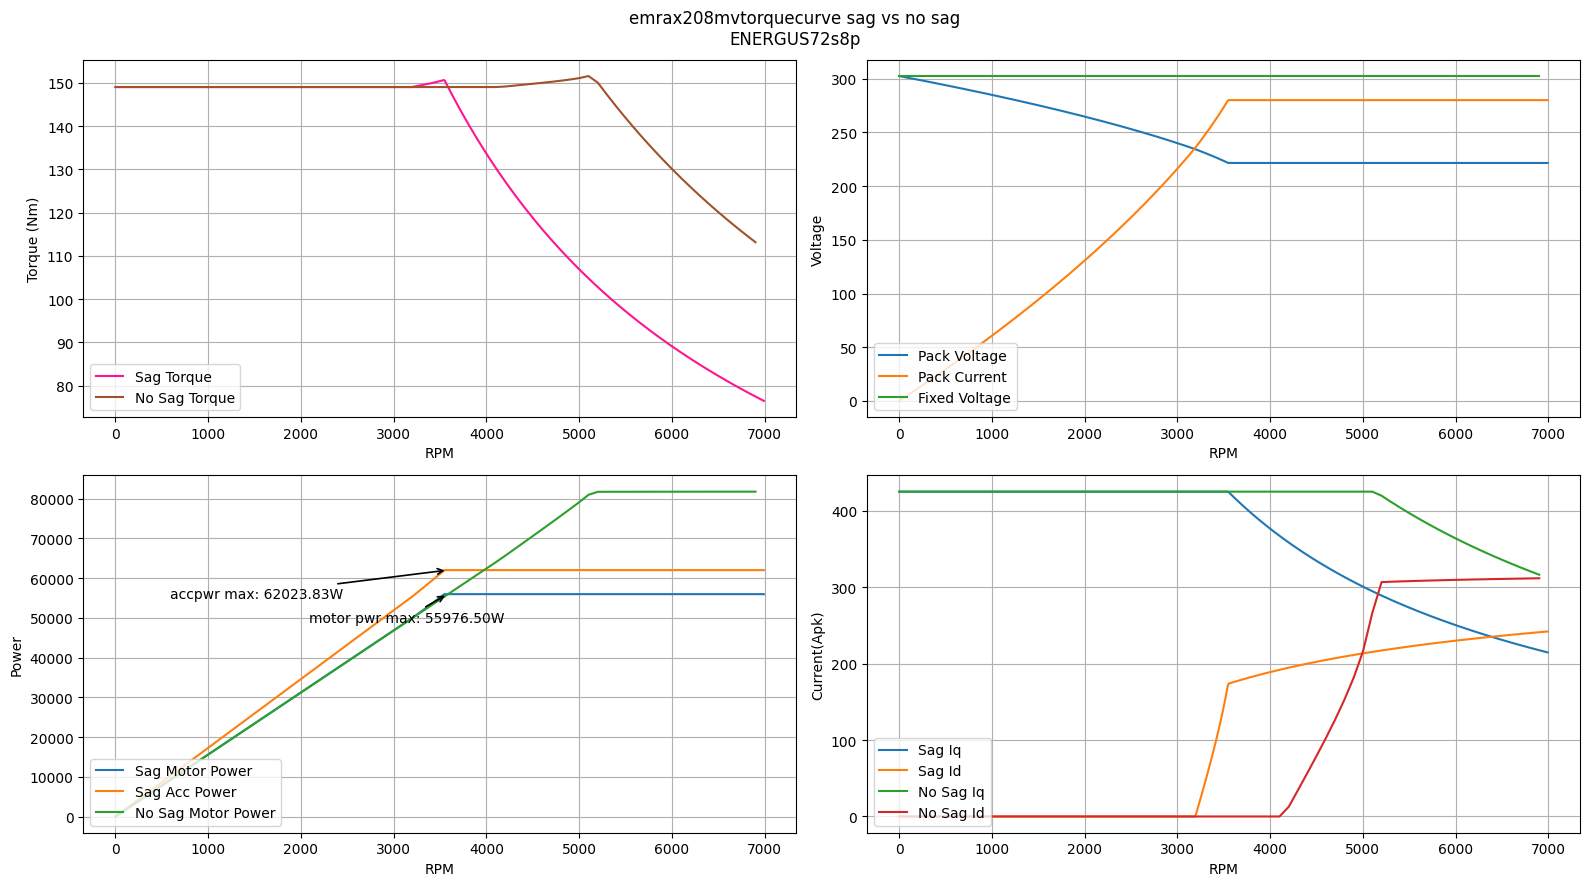

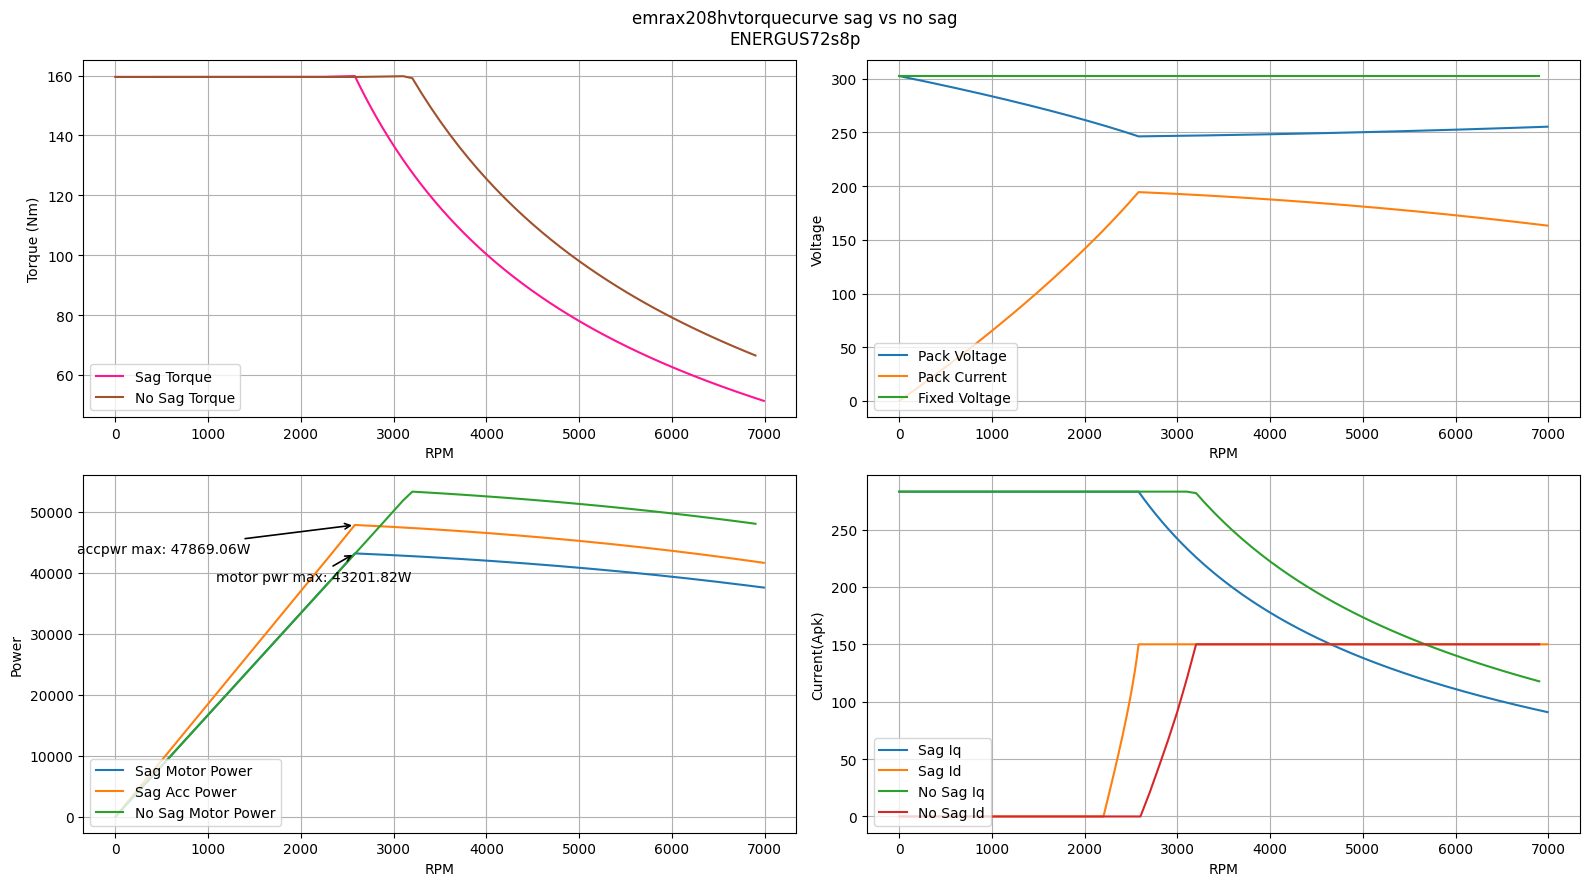

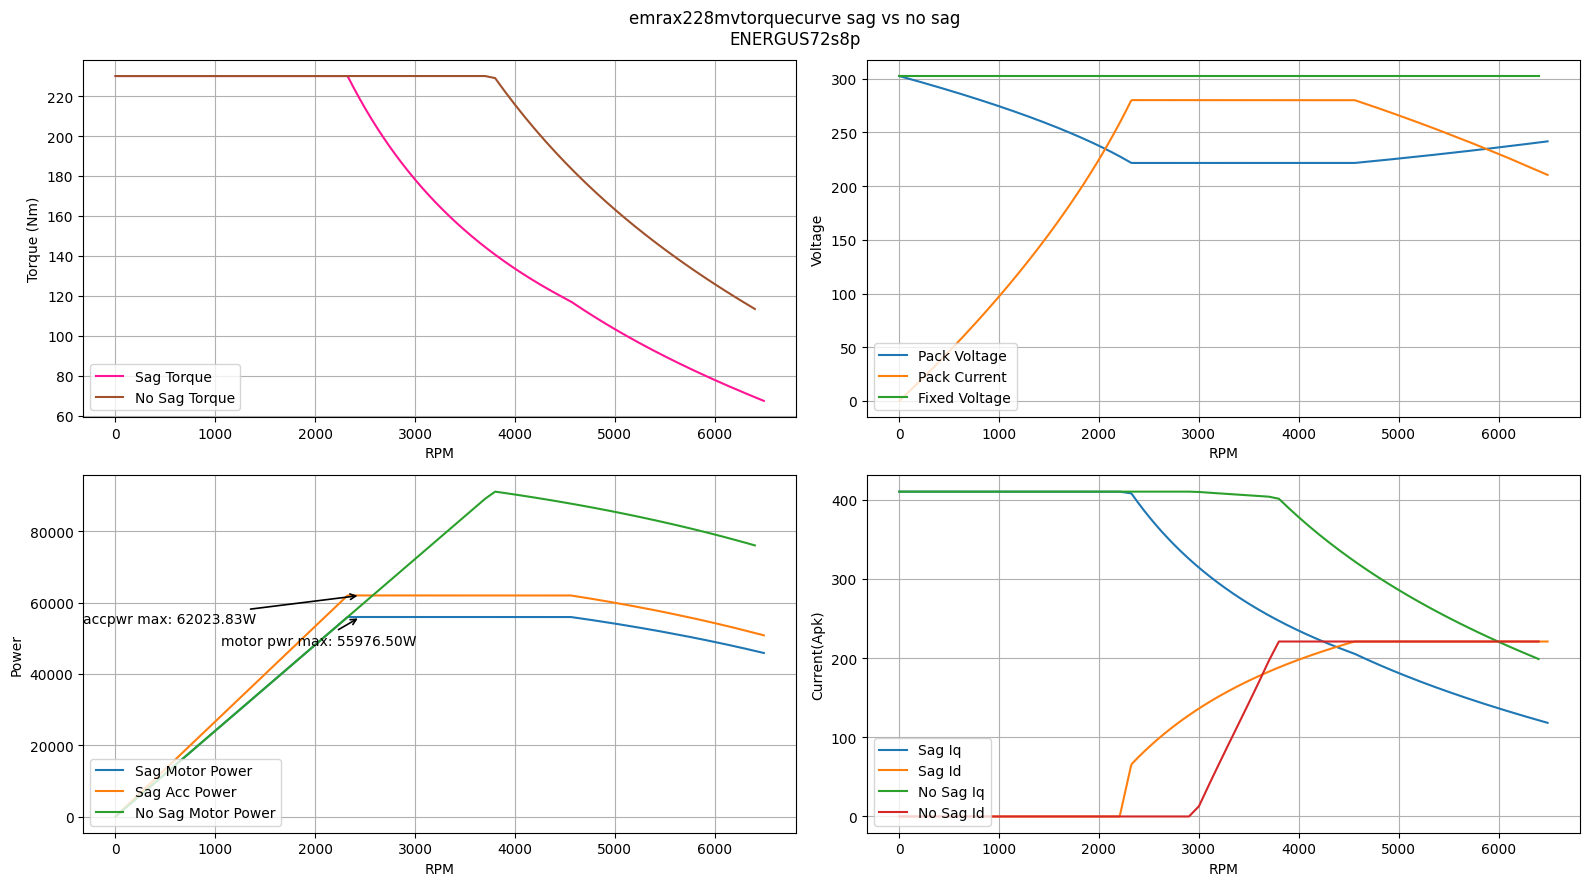

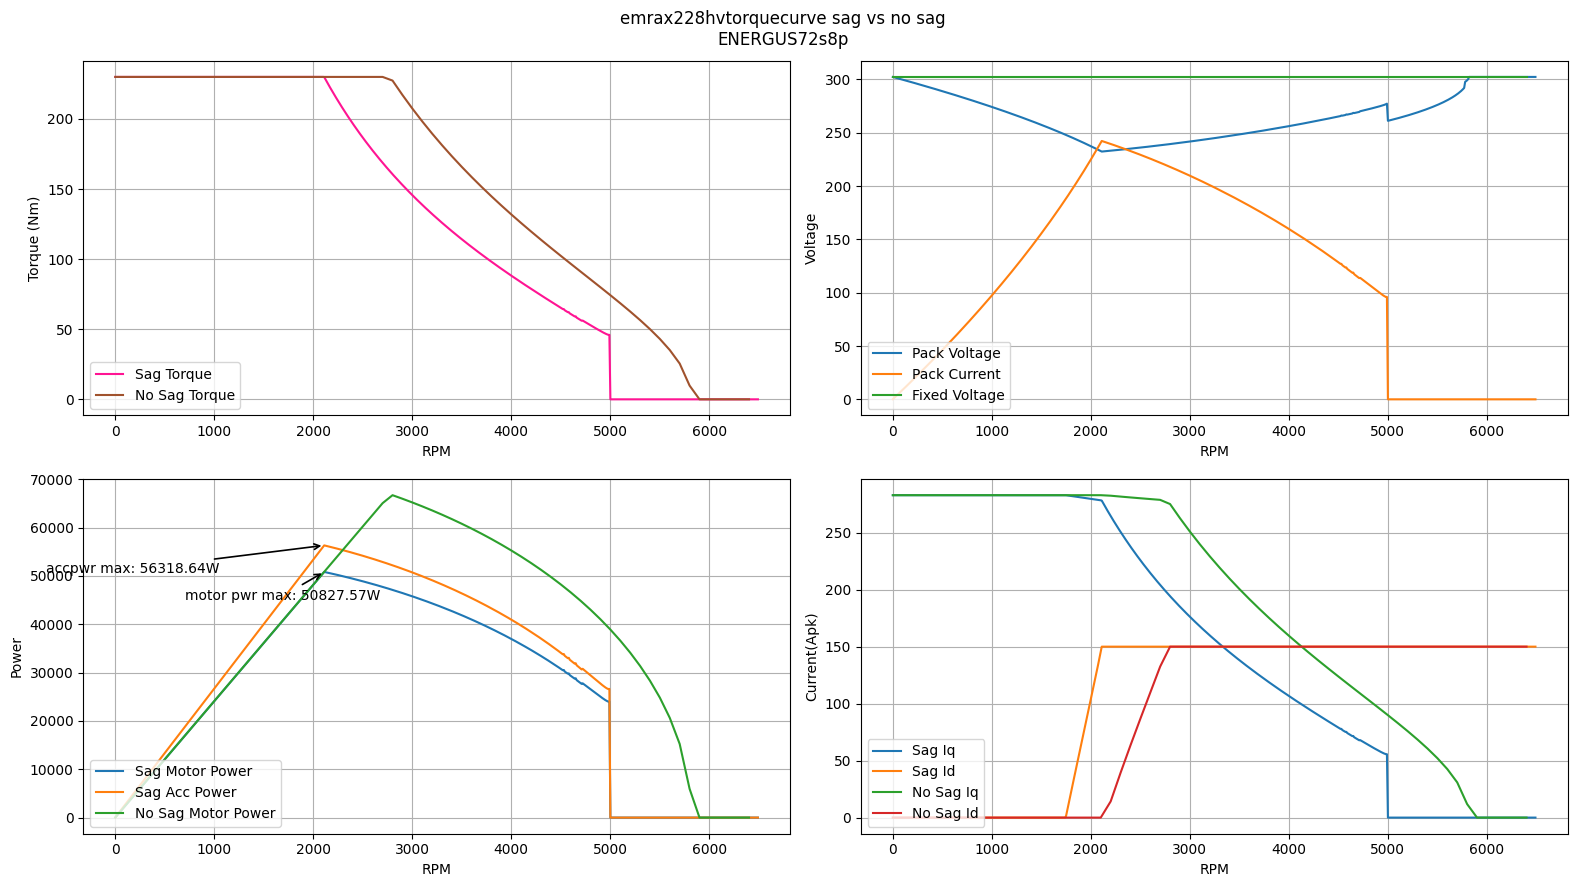

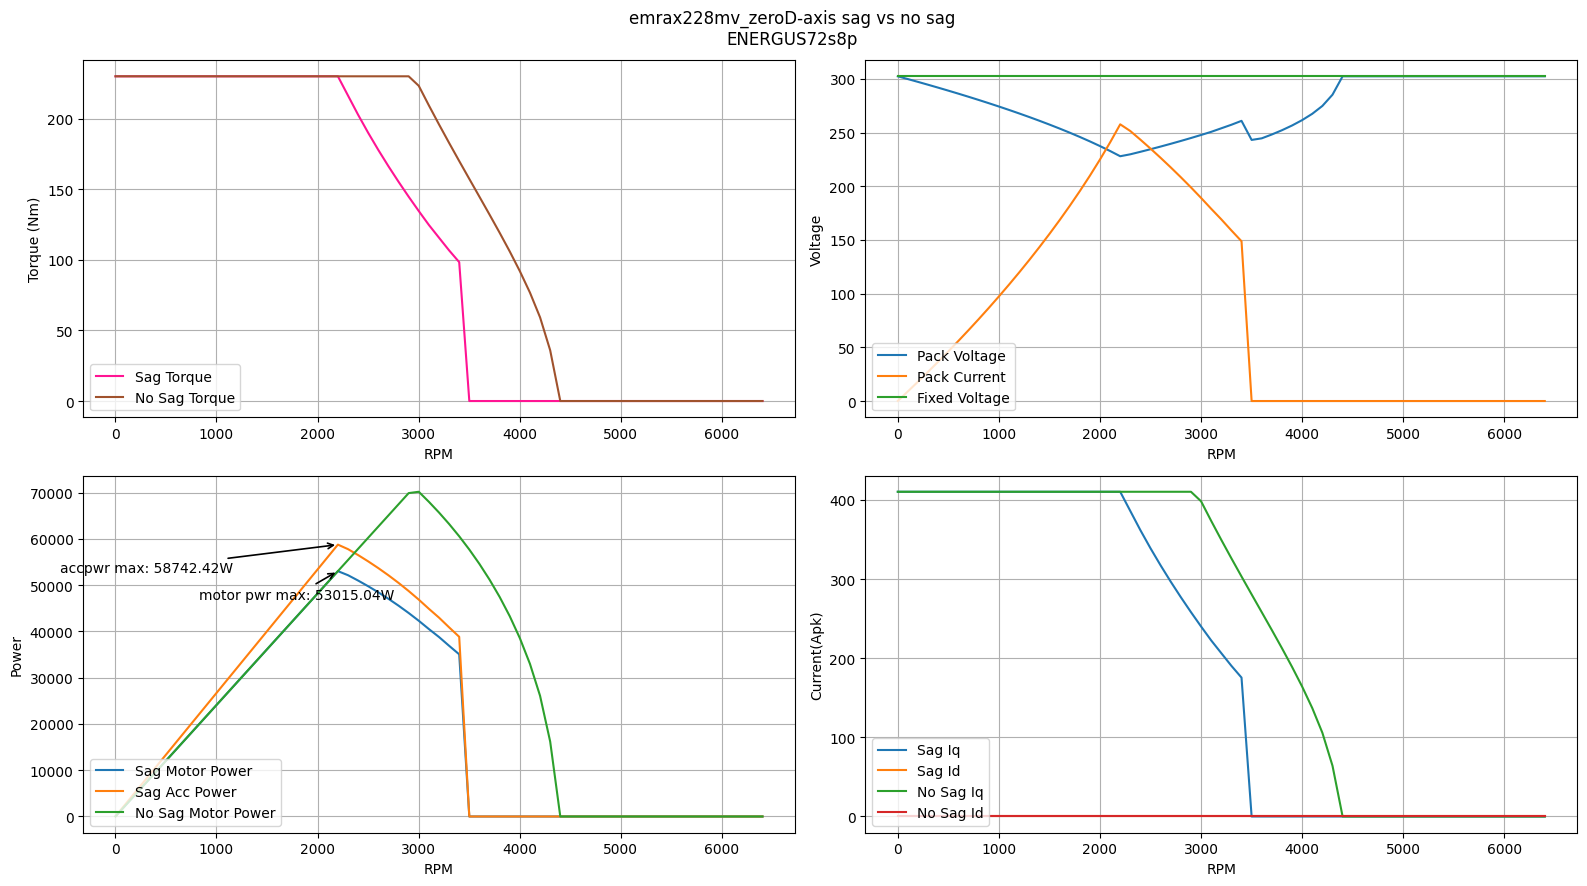

In [17]:
def annot_cols(df,cols:list,ax,unit:str,timeindex=None):
    for col in cols:
        xmax = (df[col].idxmax())
        if timeindex:
            xmax = df[timeindex][xmax]
        ymax = df[col].max()
        ax.annotate(
            f"{col} max: {ymax:.2f}{unit}",
            xy=(xmax, ymax), xycoords='data',
            xytext=(-200, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->',linewidth=1.2,color='black'))
        
colors = [
    'deeppink',
    'darkturquoise',
    'sienna',
    'maroon'
]

for key in data_list.keys():
    sagdf = data_list[key]
    nosagdf = no_sag_df_list[key]
    # plot torque, voltage, power
    fig,  ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,9))
    fig.suptitle(f"{key} sag vs no sag\n{accumulator.name}")

    ax1.plot(sagdf['rpm'],sagdf['torque'],label='Sag Torque',c=colors[0])
    ax1.plot(nosagdf['w'],nosagdf['t_t'],label='No Sag Torque',c=colors[2])
    
    ax2.plot(sagdf['rpm'],sagdf['voltage'],label='Pack Voltage')
    ax2.plot(sagdf['rpm'],sagdf['current'],label='Pack Current')
    ax2.plot(nosagdf['w'],nosagdf['v'],label='Fixed Voltage')
    
    ax3.plot(sagdf['rpm'],sagdf['motorpwr'],label='Sag Motor Power')
    # ax3.plot(sagdf['rpm'],sagdf['phasepwr'],label='sag elec pwr')
    # ax3.plot(sagdf['rpm'],sagdf['vq'])
    # ax3.plot(sagdf['rpm'],sagdf['vd'])

    ax3.plot(sagdf['rpm'],sagdf['accpwr'],label='Sag Acc Power')
    ax3.plot(nosagdf['w'],nosagdf['power'],label='No Sag Motor Power')
    ax3.annotate(
            f"motor pwr max: {sagdf['motorpwr'].max():.2f}W",
            xy=(sagdf['rpm'][sagdf['motorpwr'].idxmax()], sagdf['motorpwr'].max()), xycoords='data',
            xytext=(-100, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->',linewidth=1.2,color='black'))
    annot_cols(sagdf,['accpwr'],ax3,'W','rpm')
    ax4.plot(sagdf['rpm'],sagdf['iq'],label='Sag Iq')
    ax4.plot(sagdf['rpm'],abs(sagdf['id']),label='Sag Id')
    ax4.plot(nosagdf['w'],nosagdf['iq_t'],label='No Sag Iq')
    ax4.plot(nosagdf['w'],abs(nosagdf['id_t']),label='No Sag Id')
    
    ylabels = ["Torque (Nm)","Voltage","Power","Current(Apk)"]

    for index,axis in enumerate(plt.gcf().get_axes()):
        axis.legend(loc="lower left")
        axis.grid(visible=True)
        axis.set_ylabel(ylabels[index])
        # axis.xaxis.set_minor_locator(MultipleLocator(250))
        # axis.yaxis.set_minor_locator(MultipleLocator(10))
        axis.xaxis.grid(True,which="minor")
        axis.set_xlabel("RPM")
    plt.tight_layout()
    plt.savefig(f"{key} {accumulator.name} sag vs no sag")
    plt.show()
    

2024-03-28 21:47:52,646 [INFO] torque_log_analysis.py:45: D4_Iq: dropped 1575 rows
2024-03-28 21:47:52,651 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 7095 rows
2024-03-28 21:47:52,657 [INFO] torque_log_analysis.py:45: D2_Torque_Feedback: dropped 6 rows


['Pack_DCL', 'Pack_CCL', 'High_Temperature', 'Low_Temperature', 'Average_Temperature', 'CRC_Checksum', 'D1_Modulation_Index', 'D2_Flux_Weakening_Output', 'D3_Id_Command', 'D4_Iq_Command', 'D1_Post_Fault_Lo', 'D2_Post_Fault_Hi', 'D3_Run_Fault_Lo', 'D4_Run_Fault_Hi', 'D1_DC_Bus_Voltage', 'D2_Output_Voltage', 'D3_VAB_Vd_Voltage', 'D4_VBC_Vq_Voltage', 'APPS1', 'APPS2', 'BSE1', 'STEERING', 'RPM_FL', 'RPM_FR', 'D1_Phase_A_Current', 'D2_Phase_B_Current', 'D3_Phase_C_Current', 'D4_DC_Bus_Current', 'D1_Analog_Input_1', 'D2_Analog_Input_2', 'D3_Analog_Input_3', 'D4_Analog_Input_4', 'D5_Analog_Input_5', 'D6_Analog_Input_6', 'D1_Motor_Angle_Electrical', 'D2_Motor_Speed', 'D3_Electrical_Output_Frequency', 'D4_Delta_Resolver_Filtered', 'D1_VSM_State', 'D2_Inverter_State', 'D3_Relay_1_Status', 'D3_Relay_2_Status', 'D3_Relay_3_Status', 'D3_Relay_4_Status', 'D3_Relay_5_Status', 'D3_Relay_6_Status', 'D4_Inverter_Run_Mode', 'D4_Inverter_Discharge_State', 'D5_Inverter_Command_Mode', 'D6_Inverter_Enable_St

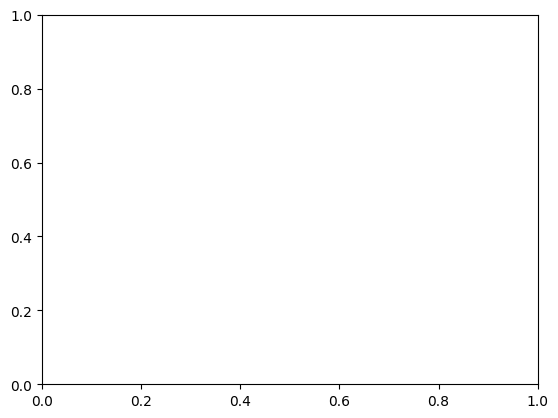

In [18]:
path = r"C:\Users\Matthew Samson\Documents\formula\4-26-2023_dyno_and_regen\parsed-data\parseddata0003.CSV"
path = r"C:\Users\Matthew Samson\Documents\formula\228hv\parsed-data\parsedMDY_3-3-2024_HMS_4-11-35.CSV"
path2 = r"C:\Users\Matthew Samson\Documents\formula\228hv\parsed-data\parsedMDY_3-3-2024_HMS_3-58-56.CSV"
experimentaldata1 = pd.read_csv(path)
experimentaldata2= pd.read_csv(path2)
experimentaldata = pd.concat([experimentaldata1,experimentaldata2])
from torque_log_analysis import resample_data,drop_rows_from_df

experimentaldata = resample_data(experimentaldata,'Time',100)
experimentaldata = drop_rows_from_df(experimentaldata,'D4_Iq',0,500)
experimentaldata = drop_rows_from_df(experimentaldata,'D1_Commanded_Torque',1,500)
experimentaldata = drop_rows_from_df(experimentaldata,'D2_Torque_Feedback',1,500)


theoreticaldata = data_list['emrax228hvtorquecurve']

print(list(experimentaldata))
print(list(theoreticaldata))

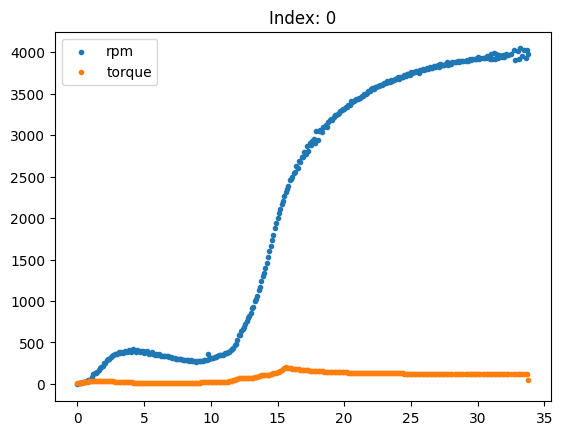

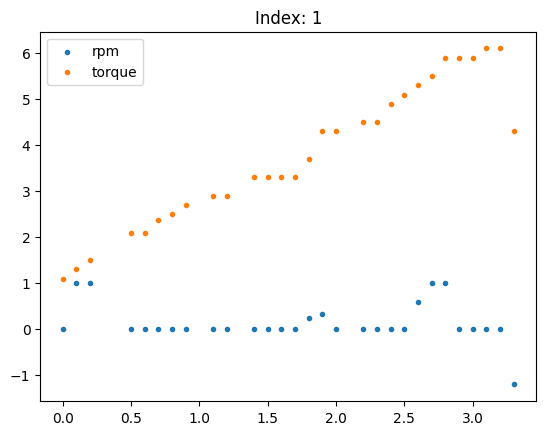

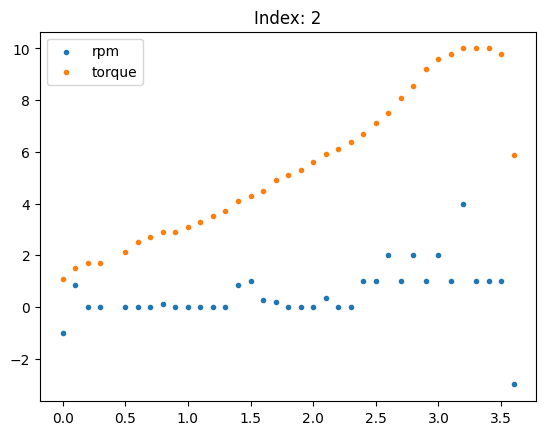

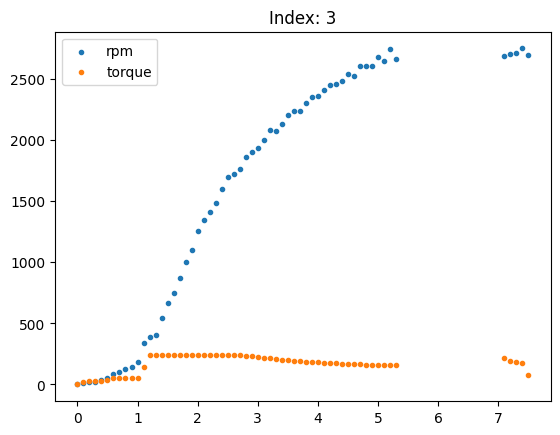

In [19]:
runs_dfs = []
experimentaldata['time_groups'] = (
    experimentaldata.index.to_series().diff().dt.seconds > 1).cumsum()

for ct, data in experimentaldata.groupby('time_groups'):
    # if data['D1_Commanded_Torque'].max() < 200:
    #     continue
    # if data['D2_Motor_Speed'].min() > 500:
    #     continue
    data['AbsoluteTime'] = (data.index - data.index.min()).total_seconds()
    data.set_index('AbsoluteTime', inplace=True)

    runs_dfs.append(data)
for index,run_data in enumerate(runs_dfs):
    plt.scatter(run_data.index,run_data['D2_Motor_Speed'],marker='.',label='rpm')
    plt.scatter(run_data.index,run_data['D1_Commanded_Torque'],marker='.',label='torque')
    plt.title(f"Index: {index}")
    plt.legend()
    plt.show()

In [20]:
experimentaldata['AbsoluteTime'] = (experimentaldata.index - experimentaldata.index.min()).total_seconds()
experimentaldata.set_index('AbsoluteTime', inplace=True)

228HV 6500.0 231 339.4112549695428 Id max: 150 Iq max: 339 Ld: 0.000177 gain: 0.0 Lq: 0.000183 gain: 0.0 Rs: 0.018 Poles: 10.0 Flux: 0.0542


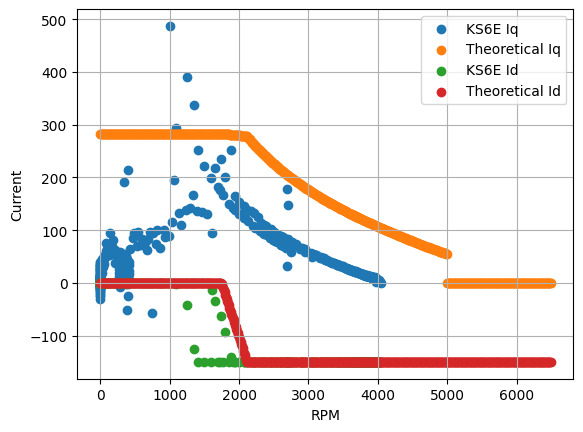

In [21]:
plt.scatter(experimentaldata['D2_Motor_Speed'],experimentaldata['D4_Iq_Command'],label='KS6E Iq')
plt.scatter(theoreticaldata['rpm'],theoreticaldata['iq'],label='Theoretical Iq')
plt.scatter(experimentaldata['D2_Motor_Speed'],experimentaldata['D3_Id_Command'],label='KS6E Id')
plt.scatter(theoreticaldata['rpm'],theoreticaldata['id'],label='Theoretical Id')
plt.grid(True)
plt.xlabel("RPM")
plt.ylabel("Current")
plt.legend()
print(EMRAX228HV)

In [22]:
from motor import pdcalcc
experimentaldata[["id","iq","t","w","vmax"]] = experimentaldata.apply(pdcalcc,rpmkey='D2_Motor_Speed',torquekey='D1_Commanded_Torque',voltagekey='D1_DC_Bus_Voltage',motor=EMRAX228HV,axis=1)


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning: invalid value encountered in sqrt
  I_q_fw = np.sqrt((v_max**2/w_e**2)-(self.Ld*I_d_fw+self.Fl)**2)/self.Lq # self.Fl +
c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


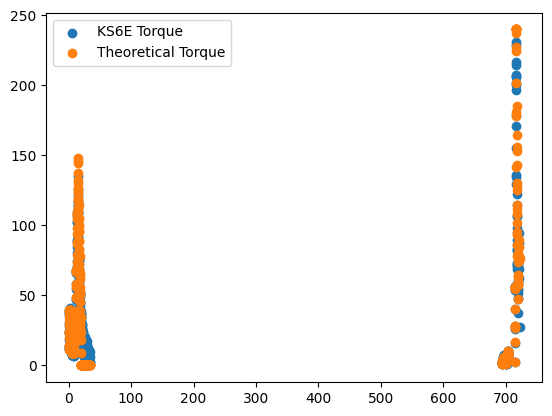

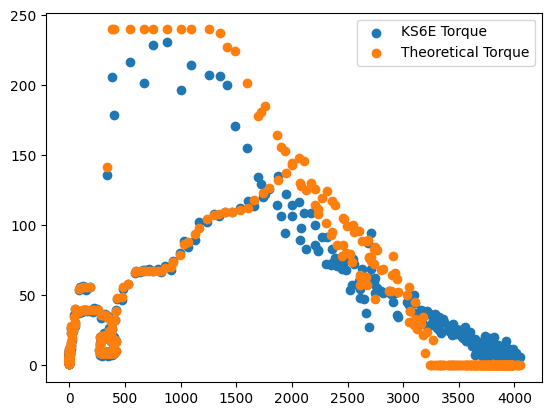

In [23]:
plt.scatter(experimentaldata.index,experimentaldata['D2_Torque_Feedback'],label='KS6E Torque')
plt.scatter(experimentaldata.index,experimentaldata['t'],label='Theoretical Torque')
# plt.xlim((90,150))
plt.legend()
plt.show()
plt.scatter(experimentaldata['D2_Motor_Speed'],experimentaldata['D2_Torque_Feedback'],label='KS6E Torque')
plt.scatter(experimentaldata['D2_Motor_Speed'],experimentaldata['t'],label='Theoretical Torque')
# plt.xlim((90,150))
plt.legend()

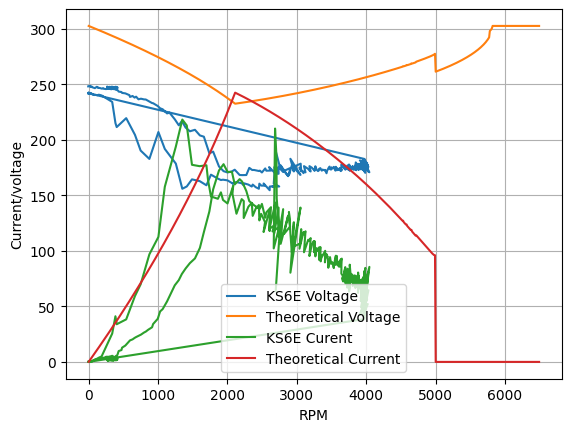

In [24]:
plt.plot(experimentaldata['D2_Motor_Speed'],experimentaldata['D1_DC_Bus_Voltage'],label='KS6E Voltage')
plt.plot(theoreticaldata['rpm'],theoreticaldata['voltage'],label='Theoretical Voltage')
plt.plot(experimentaldata['D2_Motor_Speed'],experimentaldata["D4_DC_Bus_Current"],label='KS6E Curent')
plt.plot(theoreticaldata['rpm'],theoreticaldata['current'],label='Theoretical Current')
plt.grid(True)
plt.xlabel("RPM")
plt.ylabel("Current/voltage")
plt.legend()

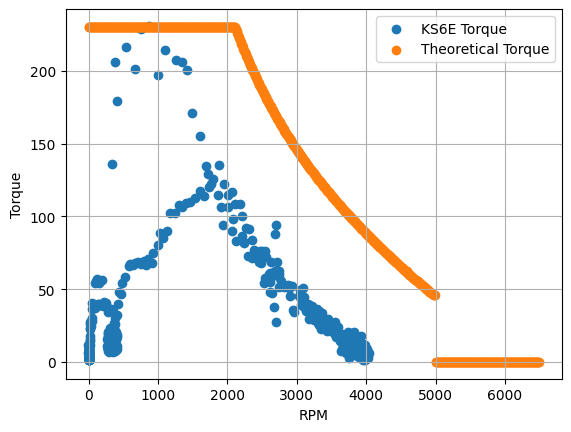

In [25]:
plt.scatter(experimentaldata['D2_Motor_Speed'],experimentaldata['D2_Torque_Feedback'],label='KS6E Torque')
plt.scatter(theoreticaldata['rpm'],theoreticaldata['torque'],label='Theoretical Torque')
plt.grid(True)
plt.xlabel("RPM")
plt.ylabel("Torque")
plt.legend()

In [26]:
calc_motor_battery_instantaneous_power(accumulator,EMRAX228HV,6100,230)

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning: invalid value encountered in sqrt
  I_q_fw = np.sqrt((v_max**2/w_e**2)-(self.Ld*I_d_fw+self.Fl)**2)/self.Lq # self.Fl +


(-150, 0, 0.0, 0.0, 0.0, 0.0, 302.40566628424364, 168.48459024422442)